# LING 83800 Homework 2 practice

In this homework practice, we will be using finite state machines to restore spaces between words using pynini.

## Instructions

1. Clone this repository to your local machine
1. Make sure pynini is installed (`conda install -c conda-forge pynini`)
1. Complete the cells with instructions

## Tips

You will find the [pynini documentation](http://www.openfst.org/twiki/bin/view/GRM/PyniniDocs) useful in completing this assignment.

Particularly useful pynini functions for this assignment are:
   * `pynini.cdrewrite()`
   * `pynini.concat()`
   * `pynini.compose()`
   * `pynini.invert()`
   * `pynini.shortestpath()`
   * `pynini.union()`
   * `pynini.Fst.closure()`
   * `pynini.Fst.num_states()`
   * `pynini.Fst.optimize()`
   * `pynini.Fst.project()`
   * `pynini.Fst.string()`

In [1]:
import pynini
import string

# Practicum 3

Let's go over [practicum 3](http://m.mr-pc.org/t/ling83800/2020sp/practicum3.ipynb) again

## a -> b / c __ d

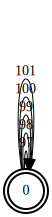

In [2]:
# sigma star is the Kleene closure over the alphabet.
sigma_star = pynini.union("a", "b", "c", "d", "e").closure().optimize()
sigma_star

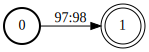

In [3]:
tau = pynini.transducer("a", "b")
tau

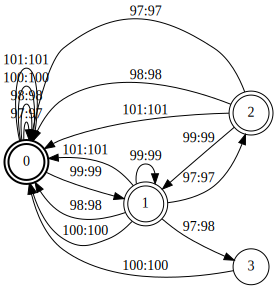

In [4]:
rule = pynini.cdrewrite(tau, "c", "d", sigma_star).optimize()
rule

In [5]:
def apply(string: str, rule: pynini.Fst) -> str:
    return (string @ rule).string()

In [6]:
apply("cab", rule)

'cab'

In [7]:
apply("cad", rule)

'cbd'

## American to British English

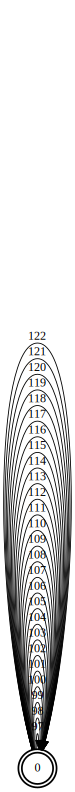

In [8]:
import string

sigma_star = pynini.union(*string.ascii_lowercase).optimize().closure().optimize()
sigma_star

In [9]:
rule_form1 = pynini.cdrewrite(pynini.transducer("ise", "ize"),
                              "",
                              "[EOS]",  # End of string special character.
                              sigma_star).optimize()
apply("colorise", rule_form1)

'colorize'

In [10]:
rule_form2 = pynini.cdrewrite(pynini.transducer("s", "z"),
                              "i",
                              "e",
                              sigma_star).optimize()
apply("optimise", rule_form2)

'optimize'

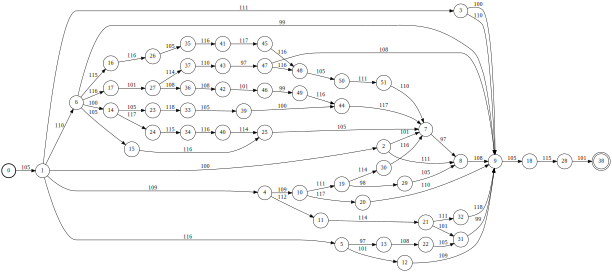

In [11]:
wordlist = ['idealise', 'idolise', 'immobilise', 'immortalise', 'immunise',
             'imprecise', 'improvise', 'incise', 'individualise', 'industrialise',
             'initialise', 'institutionalise', 'intellectualise', 'internalise',
            'internationalise', 'iodise', 'ionise', 'italicise', 'itemise']
british_words = pynini.union(*wordlist).optimize()
british_words

In [12]:
to_american = british_words @ rule_form2
american_words = list(to_american.paths().ostrings())
american_words

['idealize',
 'idolize',
 'immobilize',
 'immortalize',
 'immunize',
 'imprecize',
 'improvize',
 'incize',
 'individualize',
 'industrialize',
 'initialize',
 'institutionalize',
 'intellectualize',
 'internalize',
 'internationalize',
 'iodize',
 'ionize',
 'italicize',
 'itemize']

## Add -d.

In [13]:
add_d = pynini.cdrewrite(pynini.transducer("", "d"),
                         "",
                         "[EOS]",
                         sigma_star).optimize()
to_past = british_words @ add_d
british_past_words = list(to_past.paths().ostrings())
british_past_words

['idealised',
 'idolised',
 'immobilised',
 'immortalised',
 'immunised',
 'imprecised',
 'improvised',
 'incised',
 'individualised',
 'industrialised',
 'initialised',
 'institutionalised',
 'intellectualised',
 'internalised',
 'internationalised',
 'iodised',
 'ionised',
 'italicised',
 'itemised']

In [14]:
to_american_past = british_words @ add_d @ rule_form2
american_past_words = list(to_american_past.paths().ostrings())
american_past_words

['idealized',
 'idolized',
 'immobilized',
 'immortalized',
 'immunized',
 'imprecized',
 'improvized',
 'incized',
 'individualized',
 'industrialized',
 'initialized',
 'institutionalized',
 'intellectualized',
 'internalized',
 'internationalized',
 'iodized',
 'ionized',
 'italicized',
 'itemized']

# Kyle's example of Spanish grapheme-to-phoneme (G2P)

<https://gist.github.com/kylebgorman/124909662f1abdab9a97ef06237c557d>

In [15]:
def _rule(tau, sigma):
    return pynini.cdrewrite(tau, "", "", sigma).optimize()

def _right_rule(tau, right, sigma):
    return pynini.cdrewrite(tau, "", right, sigma).optimize()

## Alphabet.

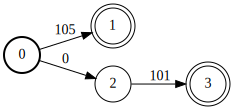

In [16]:
front_v = pynini.union("i", "e")
front_v

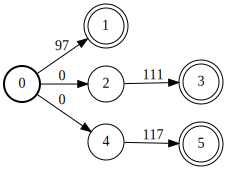

In [17]:
back_v = pynini.union("a", "o", "u")
back_v

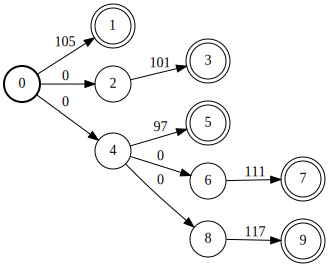

In [18]:
ph_v = front_v | back_v
ph_v

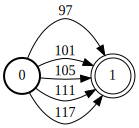

In [19]:
ph_v.optimize()

In [20]:
gr_v = pynini.union("á", "é", "í", "ó", "ú", "ý")
ph_c = pynini.union("b", "tʃ", "d", "f", "g", "j", "k", "l", "ʝ", "m",
             "n", "ɲ", "p", "r", "ɾ", "R", "s", "t", "w", "x", "z")
gr_c = pynini.union("c", "h", "ñ", "q", "v", "y")

## Closure over the alphabet---neeeded to compile rewrite rules.

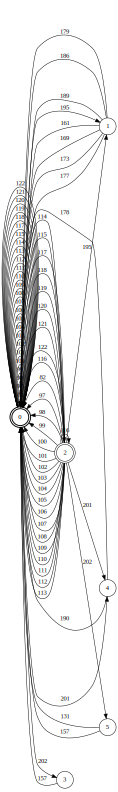

In [21]:
sigma = pynini.closure(ph_v | gr_v | ph_c | gr_c).optimize()
sigma

In [22]:
## START OF PART 4.

u_rules = _rule(pynini.string_map([
        # Digraphs.
        ("ch", "tʃ"),
        ("ll", "ʝ"),
        ("qu", "k"),
        # Removes acute accents.
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        # Other unconditioned rules.
        ("v", "b"),
        ("ñ", "ɲ"),
    ]
), sigma)

In [23]:
# TODO(kbg): This is not quite right.
r_rules = ( 
    _rule(pynini.transducer("rr", "R"), sigma) @
    _rule(pynini.transducer("r", "ɾ"), sigma) @
    _rule(pynini.transducer("R", "r"), sigma)
).optimize()

b_rules = (
    _rule(pynini.transducer("x", "ks"), sigma) @
    _rule(pynini.transducer("j", "x"), sigma) @
    _rule(pynini.transducer(pynini.union("ý", "y"), "j"), sigma) @
    _rule(pynini.transducer("hi", "j"), sigma) @
    _rule(pynini.transducer("hu", "w"), sigma) @
    _rule(pynini.transducer("h", ""), sigma)
).optimize()

k_rules = (
    _right_rule(pynini.transducer("g", "x"), front_v, sigma) @
    _right_rule(pynini.transducer("gu", "g"), front_v, sigma) @
    _rule(pynini.transducer("gü", "gw"), sigma) @
    _right_rule(pynini.transducer("c", "s"), front_v, sigma) @
    _right_rule(pynini.transducer("cu", "kw"), ph_v, sigma) @
    _rule(pynini.transducer("c", "k"), sigma)
)

In [24]:
g2p = pynini.optimize(u_rules @ r_rules @ b_rules @ k_rules)

In [25]:
def _rewrite(s, rule):
    lattice = pynini.compose(s, rule)
    if lattice.start() == pynini.NO_STATE_ID:
        return
    return pynini.shortestpath(lattice).string()

In [26]:
_rewrite("cuando", g2p)

'kwando'

In [27]:
_rewrite("hierba", g2p)

'jeɾba'

In [28]:
_rewrite("hacer", g2p)

'aseɾ'

In [29]:
_rewrite("llave", g2p)

'ʝabe'

In [30]:
_rewrite("pero", g2p)

'peɾo'

In [31]:
assert _rewrite("cuando", g2p) == "kwando"
assert _rewrite("hierba", g2p) == "jeɾba"
assert _rewrite("hacer", g2p) == "aseɾ"
assert _rewrite("llave", g2p) == "ʝabe"
assert _rewrite("pero", g2p) == "peɾo"

# Putting spaces back into sentences

## Create an FSA that accepts individual English words

I have given you a file containing the first 20 valid English words that we are considering here called "english_20.txt". Each line contains one word.

In [32]:
dictionary = open("english_20.txt").read().split("\n")
print(len(dictionary))
dictionary[:10]

21


['a',
 'aaa',
 'aaberg',
 'aachen',
 'aaker',
 'aalseth',
 'aamodt',
 'aancor',
 'aardema',
 'aardvark']

In [33]:
english = pynini.union(*dictionary).optimize()

In [34]:
english.num_states()

37

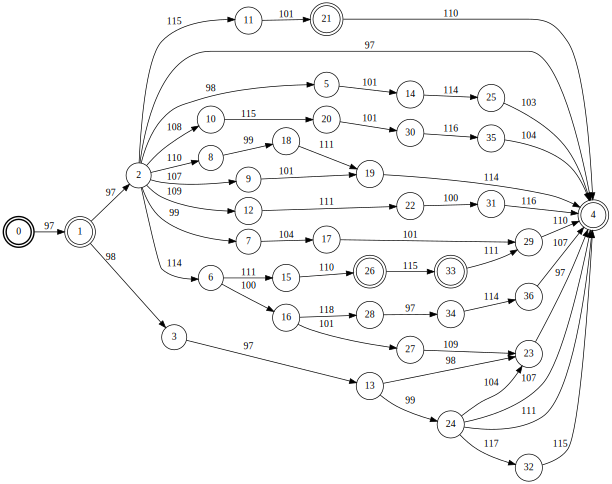

In [35]:
english

### Create the space-separated closure of english words

In [36]:
english_sentences = pynini.concat(english, " ").closure().concat(english)
english_sentences.num_states()

77

Test that it works on valid sentences

In [37]:
for sentence in ["a", "a a a", "a aaa aardvark"]:
    pynini.compose(sentence, english_sentences).string()
    print("Succeeded for", sentence)

Succeeded for a
Succeeded for a a a
Succeeded for a aaa aardvark


Test that it doesn't work on invalid sentences

In [38]:
for bad_sentence in ["sooper seekrit", "deeeecoder", "ringgg more than one word"]:
    try:
        print(pynini.compose(bad_sentence, english_sentences).string())
    except pynini.FstOpError:
        print("Correctly rejected", bad_sentence)        

Correctly rejected sooper seekrit
Correctly rejected deeeecoder
Correctly rejected ringgg more than one word


## A transducer to remove spaces

In this section, we will create an FST to remove spaces from strings.

In [39]:
alphabet = list(string.ascii_lowercase) + [" ", "-"]

### Make the transducer to remove vowels

You will need to make a `pynini.transducer()` from vowels to the empty string and then use `pynini.cdrewrite()` to make a context-dependent rewrite transducer, but don't give it any context (use the empty string for the left and right context). You will also need to define `sigma_star` the closure of the `alphabet` just defined.

In [40]:
# sigma star is the Kleene closure over the alphabet.
sigma_star = pynini.union(*alphabet).closure().optimize()

space_remover = pynini.cdrewrite(pynini.transducer(" ", ""), "", "", sigma_star)

Test that it works

In [41]:
pynini.compose("a aardvark", space_remover).string()

'aaardvark'

### Make an FST to add spaces back to strings

Use the function `pynini.invert()` to exchange the input and output strings of the FST relation.

In [42]:
space_adder = pynini.invert(space_remover)

In [43]:
lattice = pynini.compose("aaardvark", space_adder).project(True)
pynini.shortestpath(lattice).string()

'aaardvark'

## Use your english sentence FSA to require your vowel adder to emit valid english sentences

In [44]:
space_adder_valid = pynini.compose(space_adder, english_sentences)

Test it

In [45]:
for no_spaces in ["aardvark", "aaardvark", "aaaardvark", "aaaaardvark", "aaaaaardvark", "aaaaaaardvark"]:
    lattice = pynini.compose(no_spaces, space_adder_valid).project(True)
    print(pynini.shortestpath(lattice).string())

aardvark
a aardvark
a a aardvark
aaa aardvark
aaa a aardvark
aaa a a aardvark
